In [1]:
import pickle
import sys
import glob

In [2]:
# Custom class used to read legacy qdpy result files
class Custom_unpickler(pickle._Unpickler):

    current_module = {"Individual": "qdpy.phenotype", "Fitness": "qdpy.phenotype"}
    
    def find_class(self, module, name):
        if name in Custom_unpickler.current_module:
            module = Custom_unpickler.current_module[name] #backward compatibility
        sys.audit('pickle.find_class', module, name)
        if self.proto < 3 and self.fix_imports:
            if (module, name) in _compat_pickle.NAME_MAPPING:
                module, name = _compat_pickle.NAME_MAPPING[(module, name)]
            elif module in _compat_pickle.IMPORT_MAPPING:
                module = _compat_pickle.IMPORT_MAPPING[module]
        __import__(module, level=0)
        if self.proto >= 4:
            return pickle._getattribute(sys.modules[module], name)[0]
        else:
            return getattr(sys.modules[module], name)

In [3]:
import exploration as pde
from functools import partial
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
params = {'legend.fontsize': 10,
          'legend.handlelength': 2,
         'legend.title_fontsize':15,
         'axes.labelsize': 15,
         'axes.labelsize': 15}
plt.rcParams.update(params)
from matplotlib.colors import LogNorm

In [4]:
# Extract g1, g2
def convert(a, sigma,factor=4.0):
    return [a/(factor*np.sqrt(2*np.pi*sigma*sigma)),sigma]

In [5]:
def get_data(pil_file, params):
    with open(pil_file,"rb") as f:
        data = Custom_unpickler(f,fix_imports=True, encoding="ASCII", errors="strict",
          buffers=None).load()
    evolved_data = []
    for a,b in data["container"].features:
        res = data["container"].features[(a,b)]
        if res:
            res = convert(*res[0])
            scaled_values = np.array([params[i].transform(a) for i, a in enumerate(data["container"].solutions[(a,b)][0])])
            evolved_data.append(np.concatenate([res,scaled_values]))
    return evolved_data

In [6]:
params, conf = pde.load_parameters("long_run_fixed_diff.conf")
evo_final = []
# Read results from the folder ../long_run_fixed_diff
for f in glob.glob("../long_run_fixed_diff/repeat*/final.p"):
    evo_final += get_data(f, params)
evo_final_df = pd.DataFrame(evo_final,columns=["g1","g2"]+[p.name for p in params])

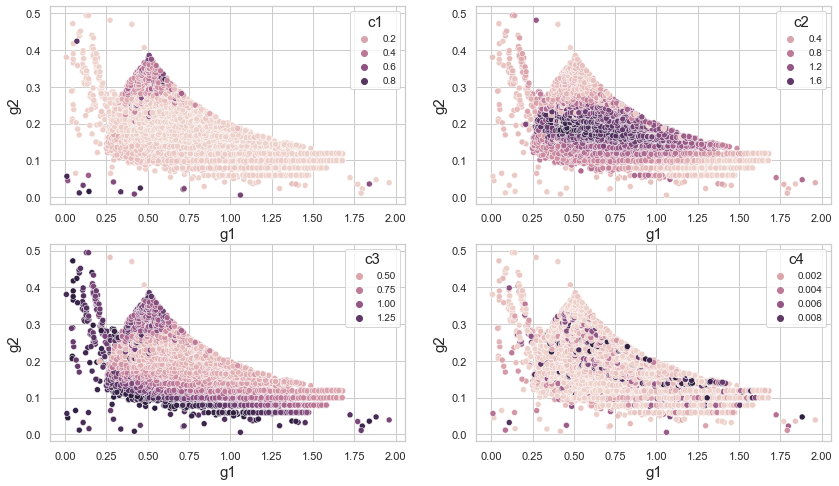

In [7]:
# Figure 4(b)
ncols = 2
nrows = 2
to_plot = ["c1", "c2", "c3", "c4"]
fig4, axs = plt.subplots(nrows, ncols,figsize=(7*nrows, 4*ncols))
for i, v in enumerate(to_plot):
    sns.scatterplot(ax=axs[i//ncols, i%ncols], x="g1", y="g2", data=evo_final_df.query("g1 < 2 and g2 < 0.5"), hue=v)

In [8]:
fig4.savefig("fig4b.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
from itertools import combinations
from matplotlib.gridspec import GridSpec

In [11]:
# Read ci parameters that were obtained from the extract_parameter script.
df_long = pd.read_csv("results_ci.dat",index_col=0)

In [12]:
# Describe the scale types of all args
ax_types = {"c1": "log", "c2": "log", "c3": "linear", "c4": "log"}
# For linear plotting, use:
#ax_types = {"c1": "linear", "c2": "linear", "c3": "linear", "c4": "linear"}
combi = [a for a in combinations(list(ax_types.keys()),2)]
print(combi)

[('c1', 'c2'), ('c1', 'c3'), ('c1', 'c4'), ('c2', 'c3'), ('c2', 'c4'), ('c3', 'c4')]


In [13]:
# To plot the average for each population
avg_df = df_long.groupby(["Condition"]).mean()

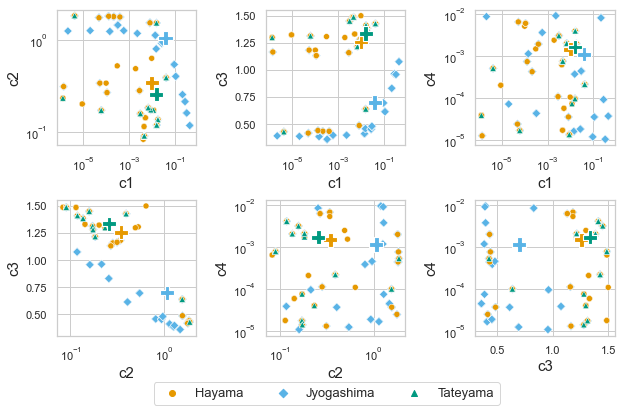

In [14]:
# Fig 5(b)
nrows = 2
ncols = int(len(combi)/2)
to_plot_pop = ['Jyogashima','Hayama','Tateyama']
f5 = plt.figure(figsize=(5*nrows, 2*ncols))
gs = GridSpec(nrows, ncols, wspace=0.5, hspace=0.4)
for i, (a, b) in enumerate(combi):
    ax = f5.add_subplot(gs[i])#plt.subplot2grid((nrows, ncols), (int(i/ncols), i % ncols))
    ax.set(xscale=ax_types[a], yscale=ax_types[b])
    sns.scatterplot(x=a, y=b, data=df_long, ax=ax, hue="Condition", 
                    palette=[(0.35,0.7,0.9), (0.9,0.6,0), (0,0.6,0.5)], style="Condition", markers=['D', 'o', '^'])
    handlers, labels = ax.get_legend_handles_labels()
    sns.scatterplot(x=a, y=b, data=avg_df.loc[to_plot_pop], ax=ax, hue="Condition", 
                    palette=[(0.35,0.7,0.9), (0.9,0.6,0), (0,0.6,0.5)], style="Condition", markers=['P', 'P', 'P'], s=200)
    
    ax.get_legend().remove()
    
f5.legend([handlers[1],handlers[0],handlers[2]], [labels[1],labels[0],labels[2]], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=13)

In [15]:
f5.savefig("fig5b.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


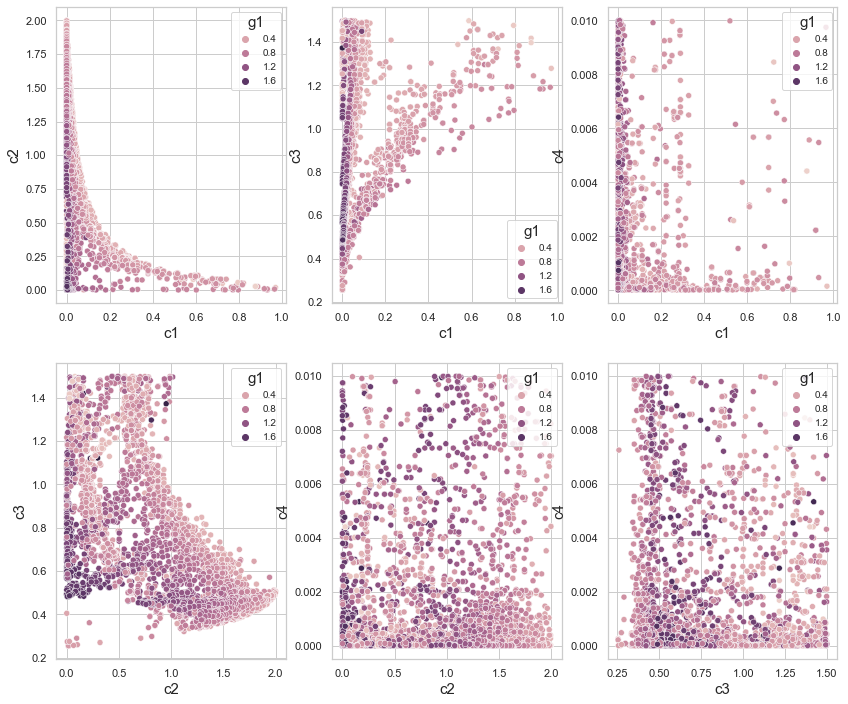

In [23]:
# Figure sup
# combi = [("c1","c2"),("c2","c3"), ("c2","c4")]
nrows = 2
ncols = int(len(combi)/2)
to_plot = ["c1", "c2", "c3", "c4"]
figmore1, axs = plt.subplots(nrows, ncols,figsize=(7*nrows, 4*ncols))
for i, (a, b) in enumerate(combi):
    sns.scatterplot(ax=axs[i//ncols, i%ncols], x=a, y=b, data=evo_final_df.query("g1 < 2 and g2 < 0.5"), hue="g1")

In [24]:
figmore1.savefig("figmore1.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


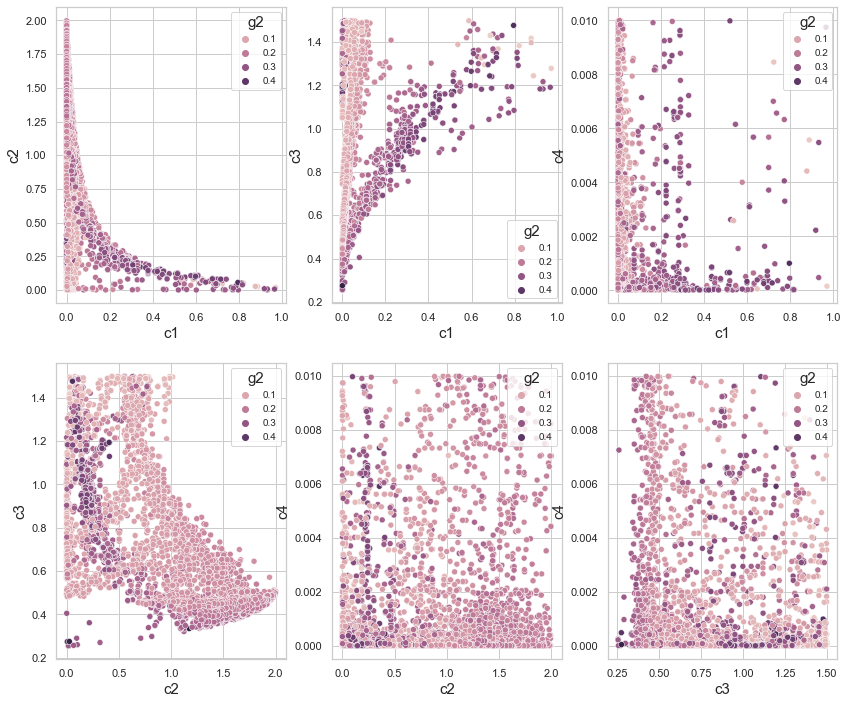

In [25]:
# Figure sup
nrows = 2
ncols = int(len(combi)/2)
to_plot = ["c1", "c2", "c3", "c4"]
figmore2, axs = plt.subplots(nrows, ncols,figsize=(7*nrows, 4*ncols))
for i, (a, b) in enumerate(combi):
    sns.scatterplot(ax=axs[i//ncols, i%ncols], x=a, y=b, data=evo_final_df.query("g1 < 2 and g2 < 0.5"), hue="g2")

In [26]:
figmore2.savefig("figmore2.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
